# 02 EDA and Media Math
This notebook explores the synthetic campaign data and defines media-math helper
functions such as *reach curves* and *deduped reach approximations*.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.float_format", "{:,.2f}".format)

df = pd.read_csv("../data/raw/campaign_daily.csv", parse_dates=["date"])
print("Shape:", df.shape)
df.head()

Shape: (1825, 10)


,date,channel,spend,cpm,impressions,clicks,conversions,est_reach,dow,is_weekend
0,2024-01-01,LinearTV,"67,450.71",25,"2,698,028.49","105,977.91",25.88,"41,702.19",0,0
1,2024-01-01,Streaming,"42,790.41",18,"2,377,245.16","91,102.94",34.05,"37,839.41",0,0
2,2024-01-01,YouTube,"22,065.79",12,"1,838,815.42","31,761.86",21.13,"30,771.88",0,0
3,2024-01-01,Display,"5,202.94",8,"650,367.65","14,079.92",17.80,"12,196.91",0,0
4,2024-01-01,Social,"9,275.93",6,"1,545,987.96","43,663.03",8.89,"26,596.43",0,0


In [3]:
df.info()
df.describe().T
df['channel'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1825 non-null   datetime64[ns]
 1   channel      1825 non-null   object        
 2   spend        1825 non-null   float64       
 3   cpm          1825 non-null   int64         
 4   impressions  1825 non-null   float64       
 5   clicks       1825 non-null   float64       
 6   conversions  1825 non-null   float64       
 7   est_reach    1825 non-null   float64       
 8   dow          1825 non-null   int64         
 9   is_weekend   1825 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 142.7+ KB


channel
LinearTV     365
Streaming    365
YouTube      365
Display      365
Social       365
Name: count, dtype: int64

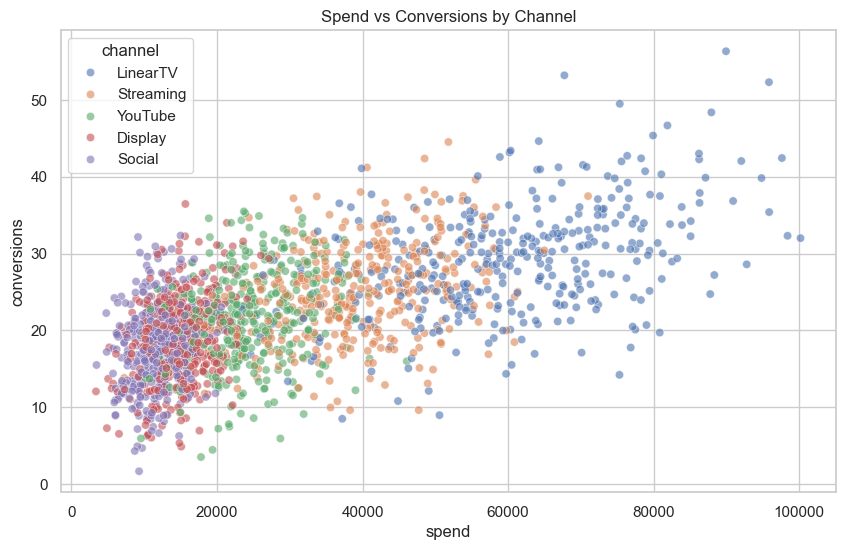

In [4]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="spend", y="conversions", hue="channel", alpha=0.6)
plt.title("Spend vs Conversions by Channel")
plt.show()

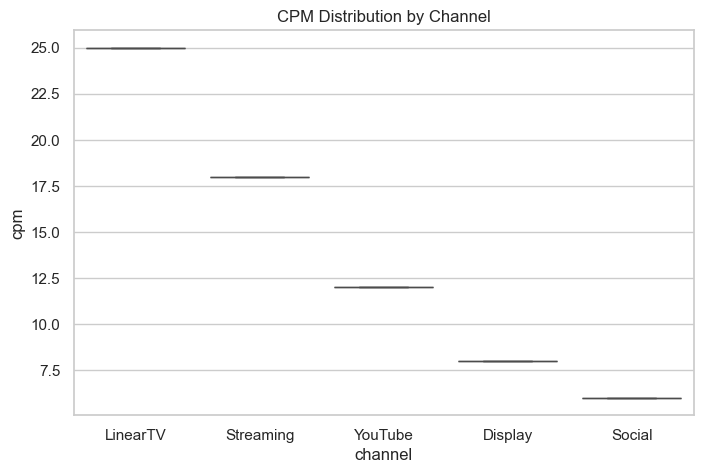

In [5]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="channel", y="cpm")
plt.title("CPM Distribution by Channel")
plt.show()

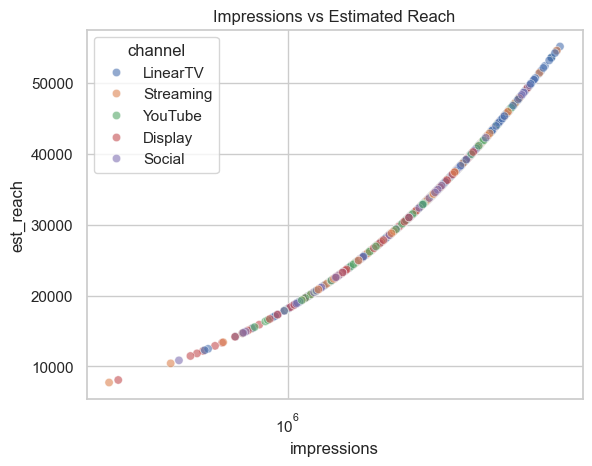

In [7]:
sns.scatterplot(data=df, x="impressions", y="est_reach", hue="channel", alpha=0.6)
plt.title("Impressions vs Estimated Reach")
plt.xscale("log")
plt.show()

In [8]:
def reach_from_impressions(impressions, A=1.0, k=1e-7):
    """
    impressions : number of impressions delivered
    A : asymptotic max fraction of audience reachable (0 < A ≤ 1)
    k : curvature factor controlling saturation speed
    """
    return A * (1 - np.exp(-k * impressions))

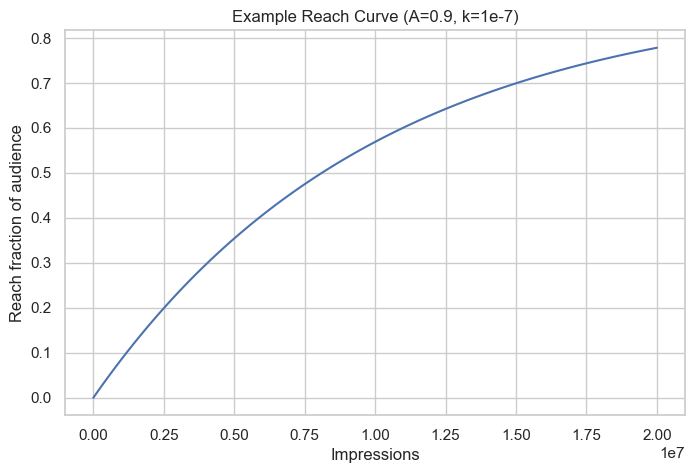

In [9]:
impr = np.linspace(0, 20e6, 100)
plt.figure(figsize=(8,5))
plt.plot(impr, reach_from_impressions(impr, A=0.9, k=1e-7))
plt.xlabel("Impressions")
plt.ylabel("Reach fraction of audience")
plt.title("Example Reach Curve (A=0.9, k=1e-7)")
plt.show()

In [10]:
A, k = 0.8, 1e-7  # tune if you like
df["reach_pct"] = reach_from_impressions(df["impressions"], A, k)
df["reach_people"] = df["reach_pct"] * 1_000_000  # assume 1 M target audience
df.head()

,date,channel,spend,cpm,impressions,clicks,conversions,est_reach,dow,is_weekend,reach_pct,reach_people
0,2024-01-01,LinearTV,"67,450.71",25,"2,698,028.49","105,977.91",25.88,"41,702.19",0,0,0.19,"189,175.99"
1,2024-01-01,Streaming,"42,790.41",18,"2,377,245.16","91,102.94",34.05,"37,839.41",0,0,0.17,"169,264.11"
2,2024-01-01,YouTube,"22,065.79",12,"1,838,815.42","31,761.86",21.13,"30,771.88",0,0,0.13,"134,372.51"
3,2024-01-01,Display,"5,202.94",8,"650,367.65","14,079.92",17.80,"12,196.91",0,0,0.05,"50,373.59"
4,2024-01-01,Social,"9,275.93",6,"1,545,987.96","43,663.03",8.89,"26,596.43",0,0,0.11,"114,592.93"


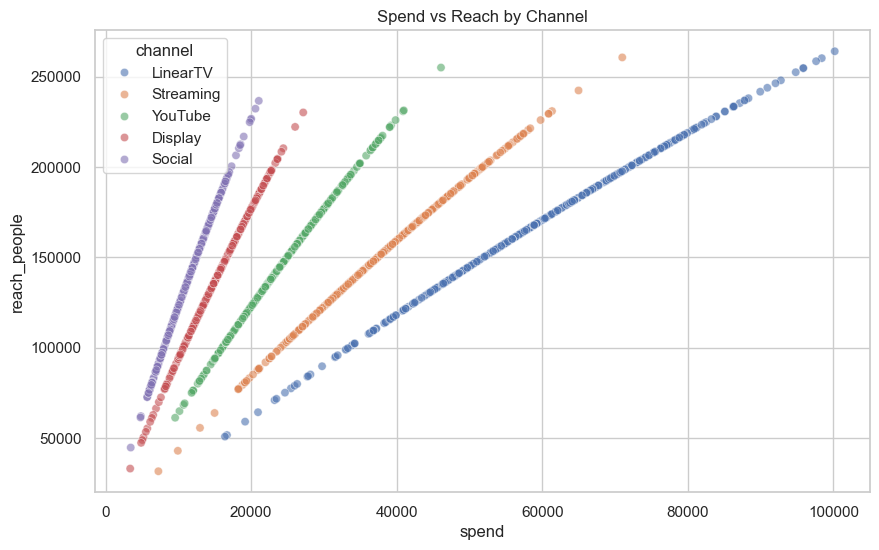

In [11]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="spend", y="reach_people", hue="channel", alpha=0.6)
plt.title("Spend vs Reach by Channel")
plt.show()

In [12]:
summary = (df.groupby("channel")[["spend","impressions","clicks","conversions","reach_people"]]
              .mean()
              .round(2))
summary

,spend,impressions,clicks,conversions,reach_people
channel,,,,,
Display,"15,151.32","1,893,915.12","56,269.07",18.92,"137,199.38"
LinearTV,"59,645.12","2,385,804.62","70,750.50",29.04,"168,534.33"
Social,"11,663.58","1,943,929.95","57,669.86",17.56,"140,509.94"
Streaming,"38,901.58","2,161,198.76","63,448.48",24.89,"154,479.87"
YouTube,"24,805.99","2,067,165.72","61,216.82",21.71,"148,509.10"


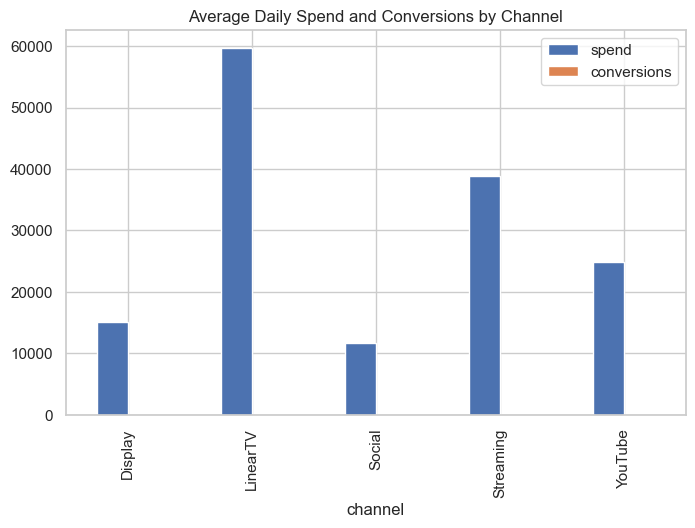

In [13]:
summary[["spend","conversions"]].plot(kind="bar", figsize=(8,5))
plt.title("Average Daily Spend and Conversions by Channel")
plt.show()

In [14]:
df.to_csv("../data/processed/campaign_daily_processed.csv", index=False)
print("✅ Saved processed dataset → data/processed/campaign_daily_processed.csv")

✅ Saved processed dataset → data/processed/campaign_daily_processed.csv
